In [1]:
# loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import datetime
import geopandas as gpd
import matplotlib.patches as mpatches

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import helper

In [2]:
import matplotlib.style as style
plt.style.use("markerr.mplstyle")

In [3]:
pd.set_option('display.max_rows', 150)

#### prepping for mapping 

In [4]:
# source: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2018.html
zips = gpd.read_file('cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp')
zips['GEOID10'] = zips['GEOID10'].astype(int)
target_zips = pd.read_csv('target.csv', index_col = 0)



In [5]:
# lists of relevent zipcodes
houston_zips_list = list(target_zips[target_zips['City']=='Houston']['zip_code'].unique())
paso_zips_list = list(target_zips[target_zips['City']=='El Paso']['zip_code'].unique())
san_zips_list = list(target_zips[target_zips['City']=='San Antonio']['zip_code'].unique())
austin_zips_list = list(target_zips[target_zips['City']=='Austin']['zip_code'].unique())
dallas_zips_list = list(target_zips[target_zips['City']=='Dallas-Fort Worth']['zip_code'].unique())

# limitting the zips to just inside the region around TX 
zips = zips[zips['AFFGEOID10'].str[0:10] == '8600000US7'].reset_index()

# limiting to the inidvidual regions of interest
houston_zips = zips.loc[zips.loc[:,'GEOID10'].isin(houston_zips_list),:]
paso_zips = zips.loc[zips.loc[:,'GEOID10'].isin(paso_zips_list),:]
san_zips = zips.loc[zips.loc[:,'GEOID10'].isin(san_zips_list),:]
austin_zips = zips.loc[zips.loc[:,'GEOID10'].isin(austin_zips_list),:]
dallas_zips = zips.loc[zips.loc[:,'GEOID10'].isin(dallas_zips_list),:]

# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# # looping the graphing to make sure it works
# for metro in different_metros.keys():
#     fig,ax = plt.subplots()
#     zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
#     different_metros[metro].plot(ax=zip_boundry_map, zorder=2, legend=False, column = 'GEOID10', cmap='hsv')

#     zip_boundry_map.axis('off')

#     minx, miny, maxx, maxy = different_metros[metro].total_bounds
#     ax.set_xlim(minx, maxx)
#     ax.set_ylim(miny, maxy)
#     plt.title(metro)
#     plt.show()

#### Loading and processing data to put into model

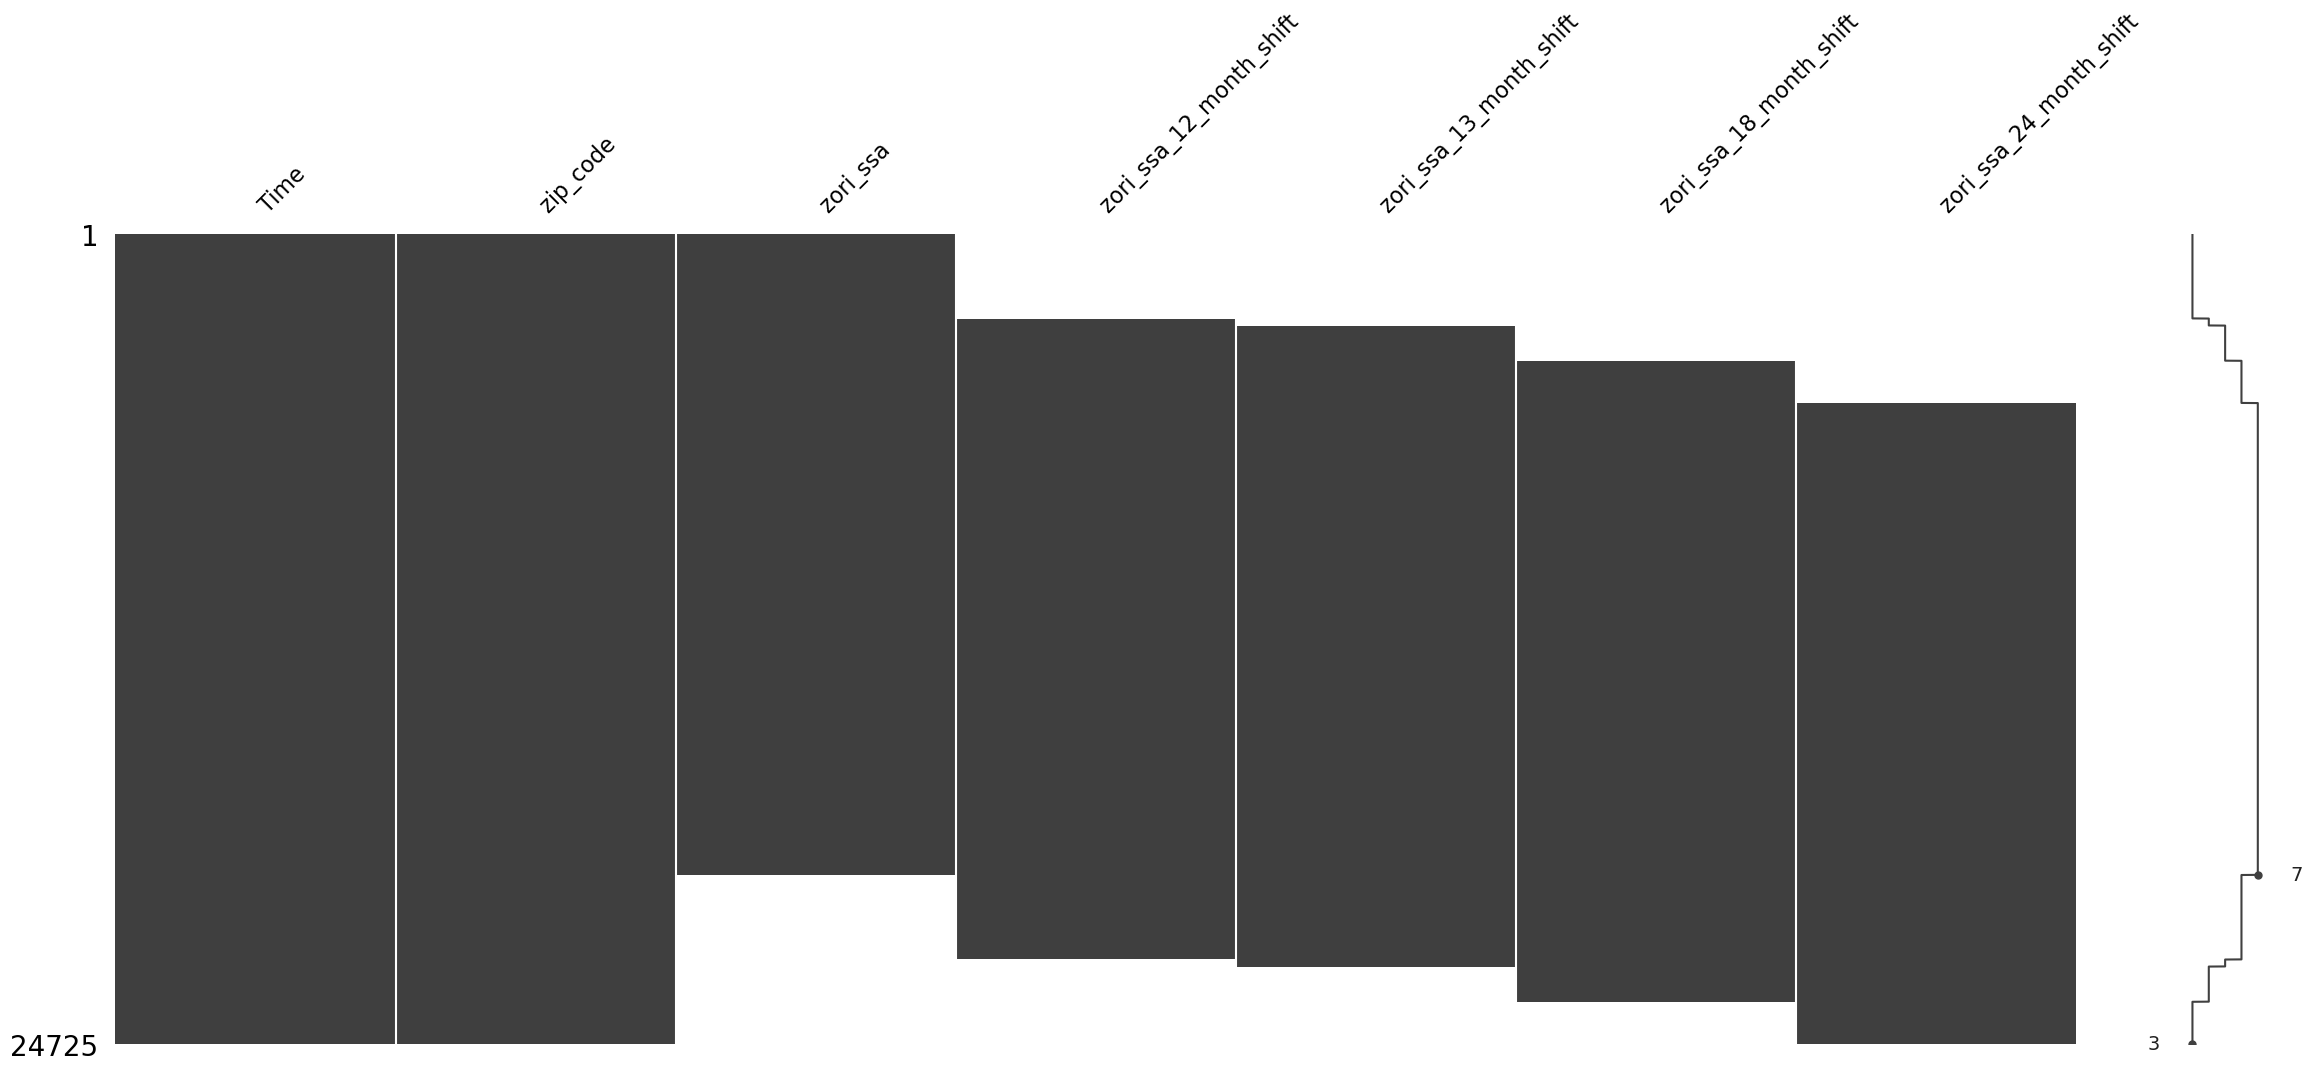

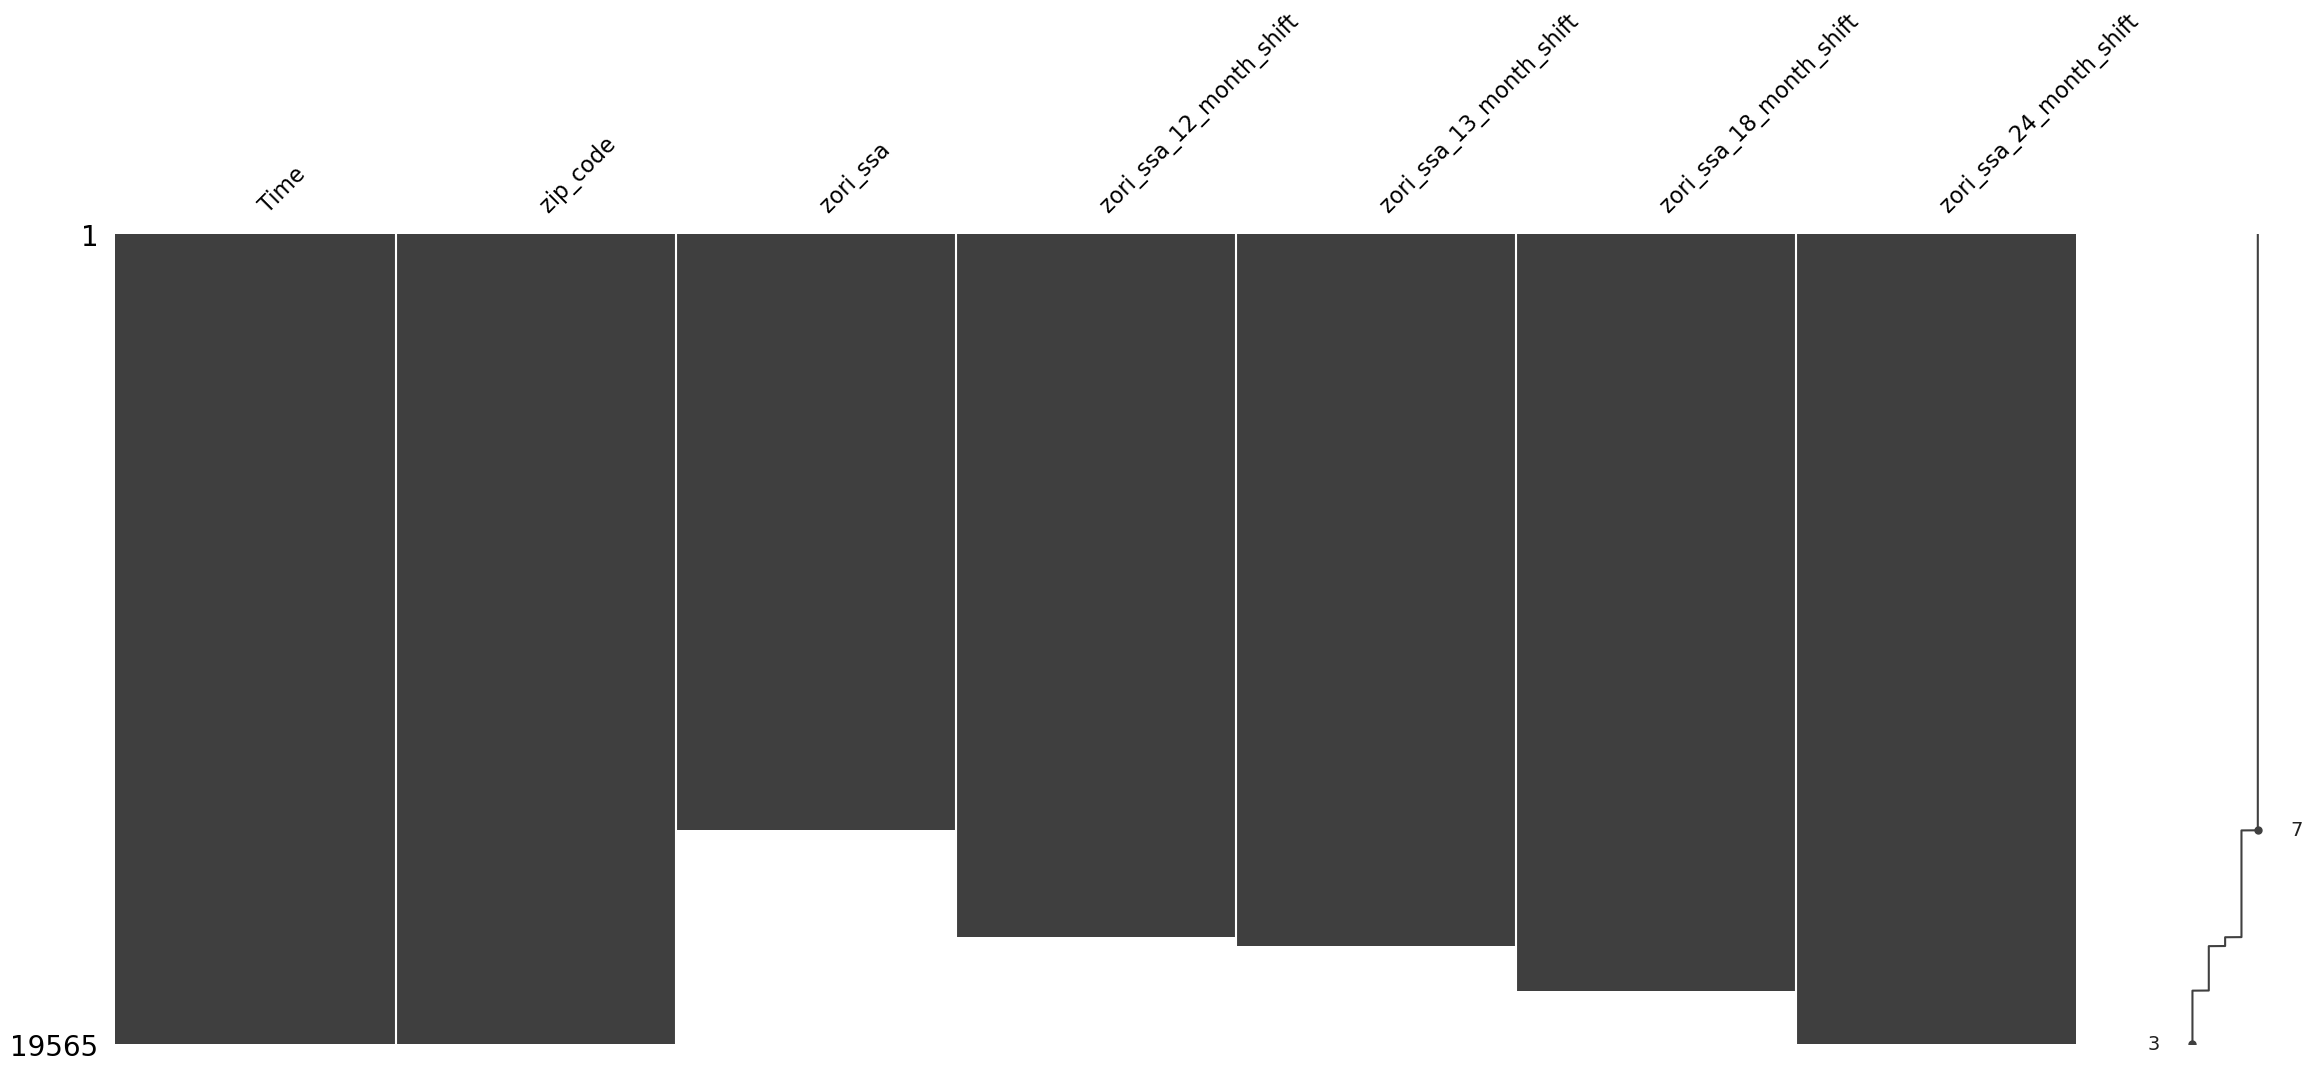

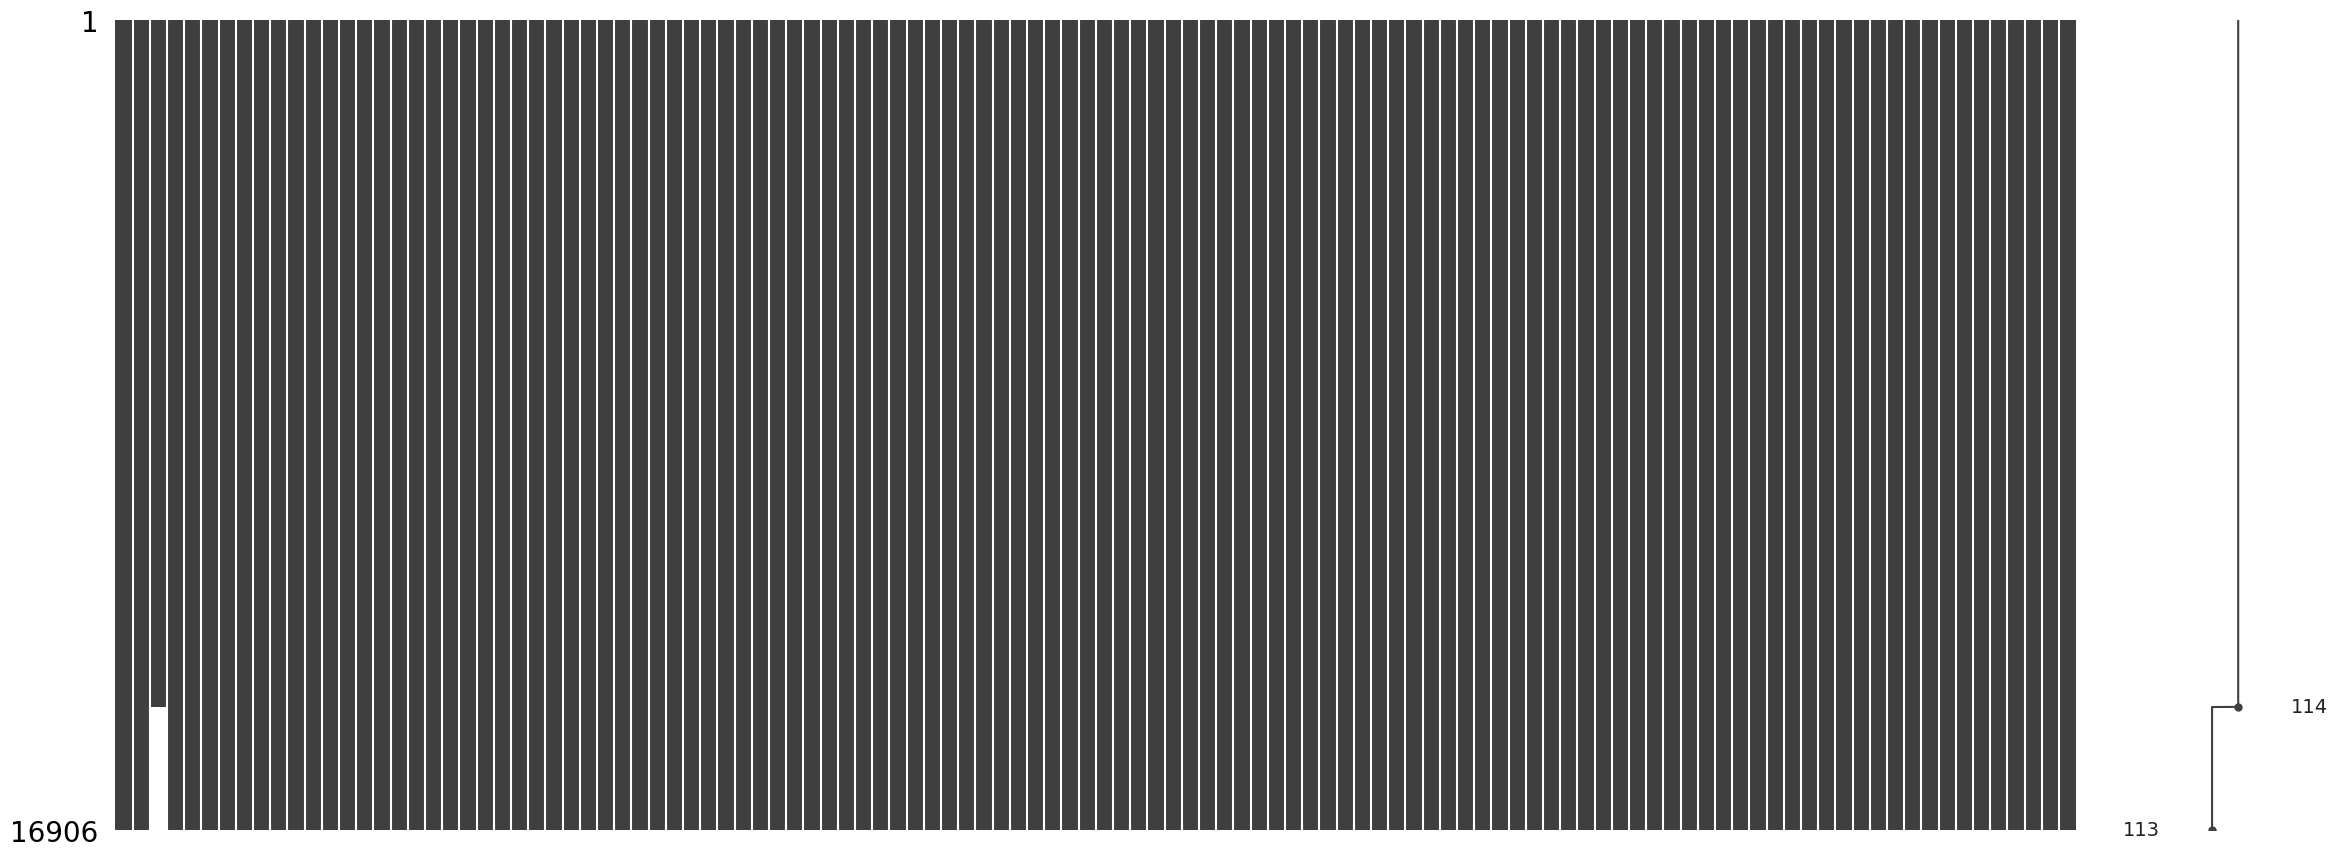

In [6]:
# load data
texas_data = pd.read_csv('merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )
#'new_feature'
# adding shift to zri
zri_shift = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa',#'new_feature'
       ],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_full = True
                                         )

# there should now be extra values after our target. 
# We are gonna remove the missing values that happen at the start of our inputs tho
zri_shift = zri_shift.sort_values('Time')
msno.matrix(zri_shift)
plt.show()


zri_shift = zri_shift.dropna(subset = ['zori_ssa_24_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)
msno.matrix(zri_shift)
plt.show()
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

zri_shift = zri_shift[['Time','zip_code','zori_ssa', #'new_feature'
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]


# merge non acs data 
extra_shift = ['Gross Value Natural Gas Production', 'sap_case_shiller_index']
merged_df = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']+extra_shift
                            ).columns),
    13:extra_shift
},
                                          return_full = True
                                         )
# merge acs data
acs_1_cols = [
    'black_pop',
    'white_pop',
    'hispanic_pop',
    'high_school_diploma',
    'female_female_households',
    'armed_forces',
    'children',
    'black_pop_annual_pct_change',
    'white_pop_annual_pct_change',
    'hispanic_pop_annual_pct_change',
    'high_school_diploma_annual_pct_change',
    'children_annual_pct_change',
    ]
merged_df = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code'] + acs_1_cols).columns),
    48:acs_1_cols                                              
},
                                          return_full = True
                                         )
# # visualize missing values. it should be that acs 2 does not have a single zipcode
# # then removing that line and checking to see that there are no more missing values.
merged_df = merged_df.loc[merged_df['Time']>datetime.datetime(2016,6,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.loc[merged_df['Time']<datetime.datetime(2022,7,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.sort_values('Time')
merged_df = merged_df.dropna(subset = ['single_women_36_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)

# this now should have no missing values except for the last year when 
# we are doing a forecast
msno.matrix(merged_df)
plt.show()

#### Adding net approve feature.

In [7]:
zri

,Time,zip_code,zori_ssa
0,2014-01-01,77494,1390.0
1,2014-02-01,77494,1387.0
2,2014-03-01,77494,1384.0
3,2014-04-01,77494,1381.0
4,2014-05-01,77494,1379.0
...,...,...,...
19560,2021-03-01,78252,1545.0
19561,2021-04-01,78252,1555.0
19562,2021-05-01,78252,1565.0
19563,2021-06-01,78252,1575.0


In [8]:
merged_df['tx_net_approve_12_month_shift'] = (merged_df['tx_is_better_12_month_shift'] - 
                                              merged_df['tx_is_worse_12_month_shift'])


#### Features to put into model. Splitting test, train, forecast

In [9]:
# creating list of variables to put into the model. initialy is all non index and target
X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
#     'housing_units_built_1960_to_1969_annual_pct_change_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
#     'housing_units_5_to_9_units_annual_pct_change_36_month_shift',
#     'median_household_income_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',
#     'female_30_to_34_annual_pct_change_36_month_shift',
#     'housing_units_over_50_units_annual_pct_change_36_month_shift',
    
    'tx_net_approve_12_month_shift'
    
]
# then remove variables that don't work for that given model.
bad_X_vals = [
             ]
X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
post_train = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = post_train.loc[post_train['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
forecast = post_train.loc[post_train['Time']>datetime.datetime(2021,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test second
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)


#### Construct model

In [10]:
lasso = Lasso(max_iter = 50000, random_state = 33)
alphas = [0.1,0.2,0.3, 0.6, 1]
tuned_parameters = [{'alpha': alphas}]
print(f'Performing Grid Search with alphas of: {alphas}')
clf = GridSearchCV(lasso, tuned_parameters, 
                    cv=5,n_jobs = -1, verbose=3,
                  scoring = 'neg_root_mean_squared_error')
# best_alpha = clf.best_params_['alpha']
clf.fit(X, y)

print(f"Best alpha {clf.best_params_['alpha']}")

Performing Grid Search with alphas of: [0.1, 0.2, 0.3, 0.6, 1]
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha 0.1


#### Creating Coefficients of Model

In [11]:
coef_df = pd.DataFrame({'features':test[X_vals].columns,'coefs':clf.best_estimator_.coef_})
unselected_coef_df = coef_df[coef_df['coefs']==0]
coef_df = coef_df[coef_df['coefs']!=0]
coef_df['coefs_abs'] = abs(coef_df['coefs'])
coef_df = coef_df.sort_values('coefs_abs',ascending=False).reset_index(drop=True)


In [12]:
coef_df

,features,coefs,coefs_abs
0,zori_ssa_12_month_shift,237.244856,237.244856
1,zori_ssa_1_diff_lag_12,26.304015,26.304015
2,zori_ssa_6_diff_lag_12,-16.864855,16.864855
3,zori_ssa_12_diff_lag_12_per,4.323890,4.323890
4,total_sales_tax_12_month_shift,-4.170712,4.170712
5,housing_units_over_50_units_36_month_shift,-3.671122,3.671122
6,housing_units_built_1960_to_1969_36_month_shift,3.401850,3.401850
7,children_annual_pct_change_48_month_shift,-2.595727,2.595727
8,black_pop_48_month_shift,2.446128,2.446128
9,housing_units_single_family_attached_owned_36_...,-2.011038,2.011038


####  Feeding test values into model

In [13]:
y_pred_test = clf.predict(X_test)
test.loc[:,'pred'] = y_pred_test
test.loc[:,'pred_difference'] = test.loc[:,y_val] - y_pred_test

rms = mean_squared_error(y_test, y_pred_test, squared=False)

In [14]:
rms

53.56478327318194

####  Feeding forecast values into model

In [15]:
y_pred_fore = clf.predict(X_forecast)
forecast.loc[:,'pred'] = y_pred_fore


#### Construct timeline of zori and what prediciton status they are.

In [16]:
# put actual data into correct format
zori_pred_act = zri[['Time','zip_code','zori_ssa']].dropna(subset=['zori_ssa'])
zori_pred_act['model_code'] = 'actual_values'
# put train into correct format
zori_pred_train = test[['Time','zip_code','pred']]
zori_pred_train.columns = ['Time','zip_code','zori_ssa']
zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
# put forecast into correct format
zori_pred_fore = forecast[['Time','zip_code','pred']]
zori_pred_fore.columns = ['Time','zip_code','zori_ssa']
zori_pred_fore['model_code'] = 'lasso_base'
# concat them together
zori_pred = pd.concat([zori_pred_act, zori_pred_train, 
                       zori_pred_fore]).reset_index(drop=True)

# zori_pred.to_csv('zori_pred_lasso_base.csv')

<ipython-input-16-8466dcc37687>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_train['model_code'] = 'lasso_base'# just code for the lasso model
<ipython-input-16-8466dcc37687>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zori_pred_fore['model_code'] = 'lasso_base'


In [17]:
# # example code 
# # create the predicted values for test
# y_pred_test = clf.predict(X_test)
# test.loc[:,'pred'] = y_pred_test
# # create the predicted values for forecast
# y_pred_fore = clf.predict(X_forecast)
# forecast.loc[:,'pred'] = y_pred_fore

# #### IMPORTANT ####
# #### Treat model_codes as a way to differentiate the different models
# #### I have laso_base for my model code. actual values will also be labeled there.
# #### it doesn't matter what you call the model it just needs
# #### to be different. and let people know what that model is
# # put train into correct format
# zori_pred_train = test[['Time','zip_code','pred']]
# zori_pred_train.columns = ['Time','zip_code','zori_ssa']
# zori_pred_train['model_codes'] = 'lasso_base'
# # put forecast into correct format
# zori_pred_fore = forecast[['Time','zip_code','pred']]
# zori_pred_fore.columns = ['Time','zip_code','zori_ssa']
# zori_pred_fore['model_codes'] = 'lasso_base'



In [18]:
test['pred_12_month_growth'] = test['pred'] - test['zori_ssa_12_month_shift']
test['actual_12_month_growth'] = test['zori_ssa'] - test['zori_ssa_12_month_shift']

test['pred_12_month_growth_per'] = test['pred_12_month_growth']/test['zori_ssa_12_month_shift']
test['actual_12_month_growth_per'] = test['actual_12_month_growth']/test['zori_ssa_12_month_shift']
test['pred_difference_per'] = test['pred_difference']/test['zori_ssa_12_month_shift']


<ipython-input-19-790110741429>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])


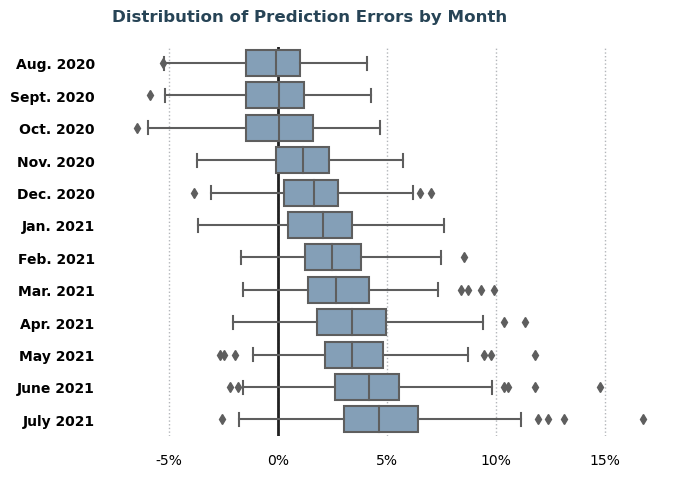

In [19]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
colors2 = ['#274456','#7BA0C0']
fig, ax = plt.subplots()
g = sns.boxplot(data = graph_df, y = 'Time',x = 'pred_difference_per', 
                color = colors2[1], ax = ax)
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')
# make the highlighted features bold. should be the same side with the visible spine
plt.yticks(fontweight='bold')

# set labels
g.set_yticklabels(labels = [
    'Aug. 2020', 'Sept. 2020', 'Oct. 2020', 'Nov. 2020',
    'Dec. 2020', 'Jan. 2021', 'Feb. 2021', 'Mar. 2021', 'Apr. 2021',
    'May 2021', 'June 2021', 'July 2021'
])



# set title
g.set(xlabel='', ylabel='',
      title='Distribution of Prediction Errors by Month\n')

# adding a vertical line at 0 percent growth
blacks = ['#212121']
plt.axvline(0, color = blacks[0], zorder = .7, linewidth = 2)

g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')



plt.show()


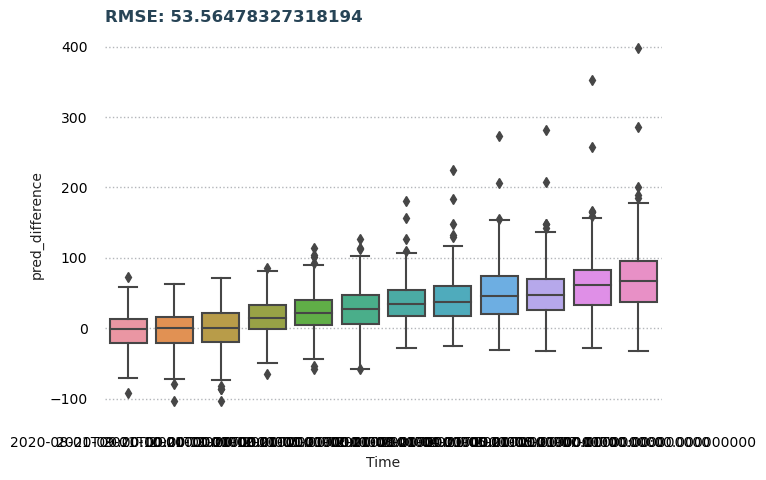

In [20]:
graph_df = test
graph_df['month'] = graph_df['Time'].dt.month
g = sns.boxplot(data = graph_df, x = 'Time',y = 'pred_difference', 
                )
plt.title(f'RMSE: {rms}')
plt.show()

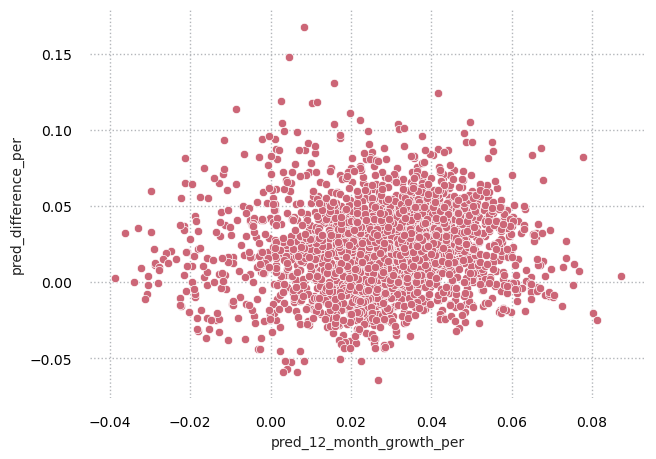

In [21]:
# is this a residual rob?
g = sns.scatterplot(
    data = test,
    x = 'pred_12_month_growth_per',
    y = 'pred_difference_per'
)
plt.show()

In [22]:
pred_growth = test.groupby('zip_code').agg(
    mean_pred_growth=('pred_12_month_growth_per', 'mean'),
    std_pred_growth=('pred_12_month_growth_per', 'std'),
    mean_act_growth=('actual_12_month_growth_per', 'mean'),
    std_act_growth=('actual_12_month_growth_per', 'std'),
    mean_naive_growth=('zori_ssa_12_diff_lag_12_per', 'mean'),
    std_naive_growth=('zori_ssa_12_diff_lag_12_per', 'std'),    
).reset_index()

# five_per_zips = pred_growth[pred_growth['pred_12_month_growth_per'
#     ]>.04].zip_code.to_list()
# naive_five_per_zips = pred_growth[pred_growth['zori_ssa_12_diff_lag_12_per'
#     ]>.04].zip_code.to_list()


In [23]:
five_per_zips = pred_growth[((pred_growth['mean_pred_growth']>.03) &
                             (pred_growth['std_pred_growth']<.025))
                           ].zip_code.to_list()
naive_five_per_zips = pred_growth[((pred_growth['mean_naive_growth']>.03) &
                             (pred_growth['std_naive_growth']<.025))
                           ].zip_code.to_list()

In [24]:
sns.color_palette()

[(0.8, 0.4, 0.4666666666666667),
 (0.2, 0.13333333333333333, 0.5333333333333333),
 (0.8666666666666667, 0.8, 0.4666666666666667),
 (0.06666666666666667, 0.4666666666666667, 0.2),
 (0.5333333333333333, 0.8, 0.9333333333333333),
 (0.5333333333333333, 0.13333333333333333, 0.3333333333333333),
 (0.26666666666666666, 0.6666666666666666, 0.6),
 (0.6, 0.6, 0.2),
 (0.6666666666666666, 0.26666666666666666, 0.6)]

In [25]:
# ['cc6677', '332288', 'ddcc77', '117733', 
#  '88ccee', '882255', '44aa99', '999933', 'aa4499']

# teal,pink,last purple, yellow, or green boi
four_colors = ['#990022','#997700','#009977','#002299']

In [26]:
test.loc[:,'invest_rec_5_per'] = 0
test.loc[test['zip_code'].isin(five_per_zips),'invest_rec_5_per'] = 3
test.loc[test['zip_code'].isin(naive_five_per_zips),'invest_rec_5_per'] = 1
test.loc[(test['zip_code'].isin(naive_five_per_zips) &
          test['zip_code'].isin(five_per_zips))
          ,'invest_rec_5_per'] = 2


pred_growth.loc[:,'invest_rec_5_per'] = 0
pred_growth.loc[pred_growth['zip_code'].isin(five_per_zips),'invest_rec_5_per'] = 3
pred_growth.loc[pred_growth['zip_code'].isin(naive_five_per_zips),'invest_rec_5_per'] = 1
pred_growth.loc[(pred_growth['zip_code'].isin(naive_five_per_zips) &
          pred_growth['zip_code'].isin(five_per_zips))
          ,'invest_rec_5_per'] = 2

In [27]:
test.loc[test['invest_rec_5_per']==3,'zip_code'].unique()

array([75189., 75211., 77088., 78109., 75040., 78238., 77539., 78213.,
       75042., 76210., 77301., 75023., 76017., 78228., 78023., 75087.,
       76227., 77459., 77095., 75002., 75068., 76053., 76065., 78209.,
       75243., 77073., 77449., 76248., 78230., 78665., 78666., 76013.])

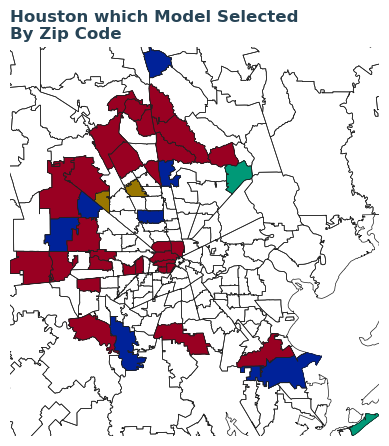

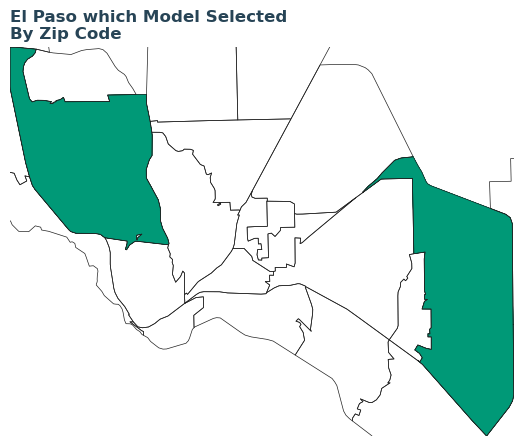

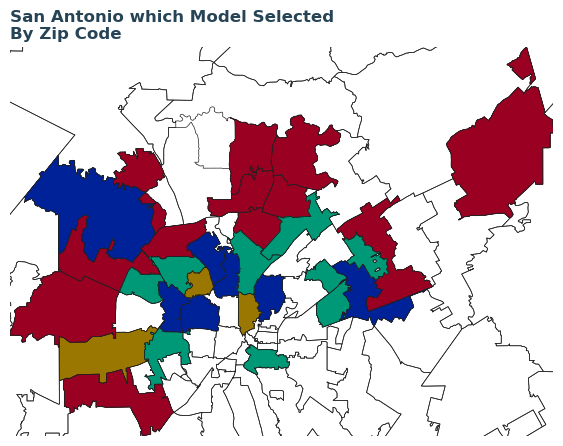

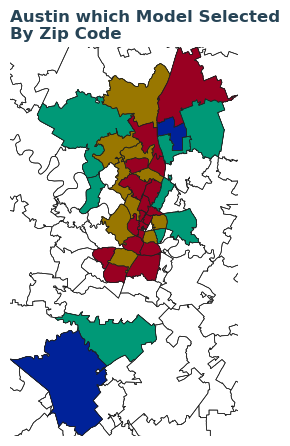

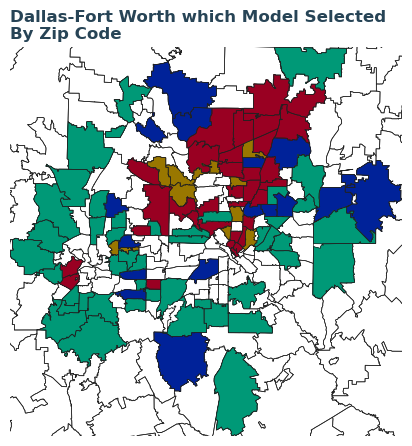

In [28]:
# color = ['#882255','#cc6677','#88ccee','#332288']
zips_code = [0,1,2,3]
color_mapping = dict(zip(zips_code,four_colors))

map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
#                      column = graph_df["invest_rec_5_per"], 
                  color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' which Model Selected\nBy Zip Code')
    plt.show()

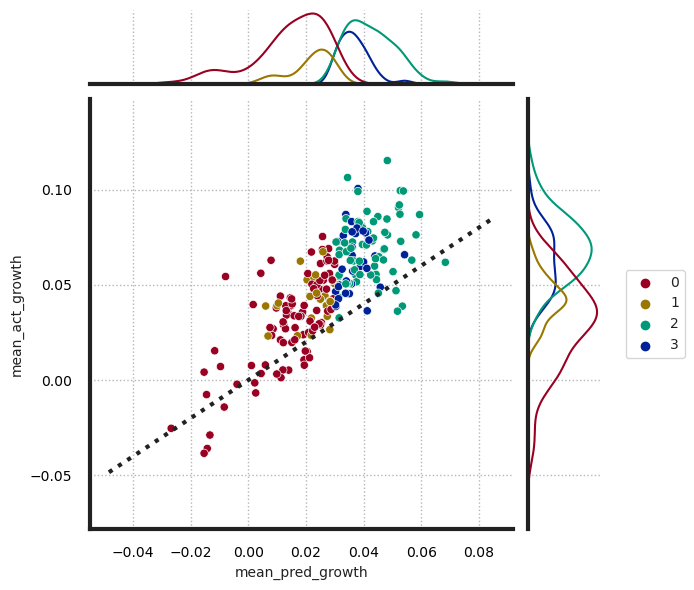

In [29]:
g = sns.JointGrid(data=pred_growth, x = 'mean_pred_growth', 
                y = 'mean_act_growth', hue='invest_rec_5_per',
                 palette = four_colors)


g.plot_joint(sns.scatterplot,)
g.plot_marginals(sns.kdeplot,legend=False)

g.ax_joint.legend(loc='center left',bbox_to_anchor=(1.25, .5))
x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, color = '#212121',linewidth=3,linestyle = 'dotted')

plt.show()

In [43]:
graph_df = pred_growth
fig, ax = plt.subplots()
g = sns.boxplot(data = graph_df, y = 'invest_rec_5_per',
                x = 'mean_act_growth', palette = four_colors[::-1],
                orient = 'h',ax = ax, order = [3,2,1,0]
                )

# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')
# make the highlighted features bold. should be the same side with the visible spine
# plt.yticks(fontweight='bold')

# # set labels
g.set_yticklabels(labels = [
    'Model selected', 'Model & naive\nselected', 
    'Naive selected', 'Neither selected'
])
# g.set_xticklabels(labels = ['','-5%','0%','5%','10%','15%'])




# set title
g.set(xlabel='', ylabel='',
      title='Distribution of Average Growth for Each ZIP Code'+
      ' \nby which Model Selected that ZIP Code')

# # adding a vertical line at 0 percent growth
# blacks = ['#212121']
plt.axvline(0, color = blacks[0], zorder = .7, linewidth = 2)

g.set_xticklabels(labels = ['','-4%','-2%','0%','2%','4%','6%',
                            '8%','10%','12%'
                           ])
# remove x axis grid lines that were cluttering the graph
ax.grid(b = None, axis = 'y')

plt.show()

ValueError: Could not interpret input 'mean_act_growth'

In [31]:
sns.color_palette()

[(0.8, 0.4, 0.4666666666666667),
 (0.2, 0.13333333333333333, 0.5333333333333333),
 (0.8666666666666667, 0.8, 0.4666666666666667),
 (0.06666666666666667, 0.4666666666666667, 0.2),
 (0.5333333333333333, 0.8, 0.9333333333333333),
 (0.5333333333333333, 0.13333333333333333, 0.3333333333333333),
 (0.26666666666666666, 0.6666666666666666, 0.6),
 (0.6, 0.6, 0.2),
 (0.6666666666666666, 0.26666666666666666, 0.6)]

In [32]:
pred_growth

,zip_code,mean_pred_growth,std_pred_growth,mean_act_growth,std_act_growth,mean_naive_growth,std_naive_growth,invest_rec_5_per
0,75002.0,0.032957,0.005889,0.075881,0.026369,0.029367,0.002257,3
1,75010.0,0.021843,0.006617,0.032508,0.014758,0.035149,0.006806,1
2,75013.0,0.026018,0.003603,0.052418,0.022304,0.026270,0.002926,0
3,75019.0,0.020382,0.008410,0.052591,0.033012,0.031284,0.011275,1
4,75022.0,0.014667,0.006780,0.038938,0.032017,0.006451,0.002889,0
...,...,...,...,...,...,...,...,...
209,78757.0,0.012126,0.008718,0.019618,0.028673,0.020216,0.016861,0
210,78758.0,0.007499,0.010954,0.027565,0.037794,0.027200,0.021024,0
211,78759.0,-0.003945,0.019428,-0.002203,0.033124,0.020663,0.026323,0
212,79912.0,0.038555,0.008212,0.062431,0.008843,0.035738,0.005008,2


In [33]:
race = pd.read_csv('race_frame.csv',index_col = 0)

In [34]:
growth_race = pred_growth.merge(race[race['year']==2021].sort_values('black_per'), on = 'zip_code')
growth_race

,zip_code,mean_pred_growth,std_pred_growth,mean_act_growth,std_act_growth,mean_naive_growth,std_naive_growth,invest_rec_5_per,year,black_per,black_to_white,non_white
0,75002.0,0.032957,0.005889,0.075881,0.026369,0.029367,0.002257,3,2021,0.097370,0.155369,0.373302
1,75010.0,0.021843,0.006617,0.032508,0.014758,0.035149,0.006806,1,2021,0.113274,0.258710,0.562159
2,75013.0,0.026018,0.003603,0.052418,0.022304,0.026270,0.002926,0,2021,0.055267,0.095033,0.418439
3,75019.0,0.020382,0.008410,0.052591,0.033012,0.031284,0.011275,1,2021,0.040754,0.071432,0.429467
4,75022.0,0.014667,0.006780,0.038938,0.032017,0.006451,0.002889,0,2021,0.026599,0.037757,0.295515
...,...,...,...,...,...,...,...,...,...,...,...,...
209,78757.0,0.012126,0.008718,0.019618,0.028673,0.020216,0.016861,0,2021,0.012770,0.018684,0.316521
210,78758.0,0.007499,0.010954,0.027565,0.037794,0.027200,0.021024,0,2021,0.075395,0.206425,0.634759
211,78759.0,-0.003945,0.019428,-0.002203,0.033124,0.020663,0.026323,0,2021,0.035157,0.051813,0.321466
212,79912.0,0.038555,0.008212,0.062431,0.008843,0.035738,0.005008,2,2021,0.020744,0.087562,0.763094


In [35]:
coef_df

,features,coefs,coefs_abs
0,zori_ssa_12_month_shift,237.244856,237.244856
1,zori_ssa_1_diff_lag_12,26.304015,26.304015
2,zori_ssa_6_diff_lag_12,-16.864855,16.864855
3,zori_ssa_12_diff_lag_12_per,4.323890,4.323890
4,total_sales_tax_12_month_shift,-4.170712,4.170712
5,housing_units_over_50_units_36_month_shift,-3.671122,3.671122
6,housing_units_built_1960_to_1969_36_month_shift,3.401850,3.401850
7,children_annual_pct_change_48_month_shift,-2.595727,2.595727
8,black_pop_48_month_shift,2.446128,2.446128
9,housing_units_single_family_attached_owned_36_...,-2.011038,2.011038


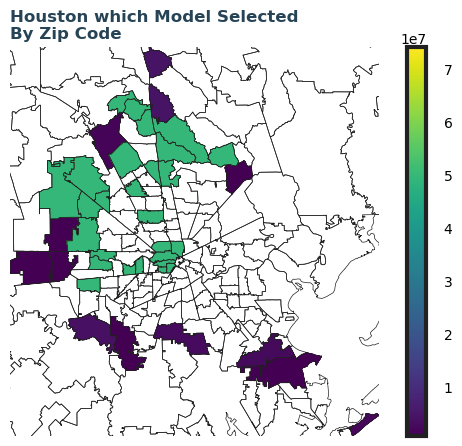

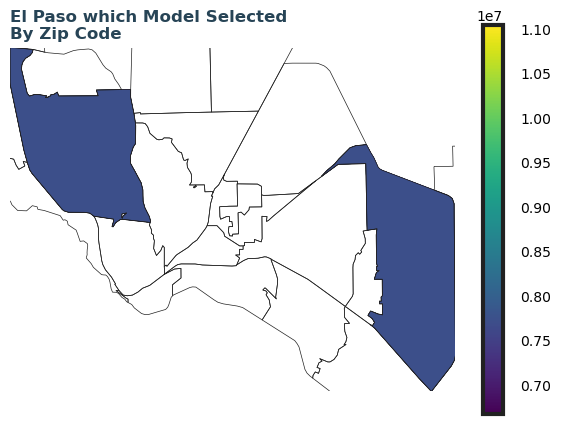

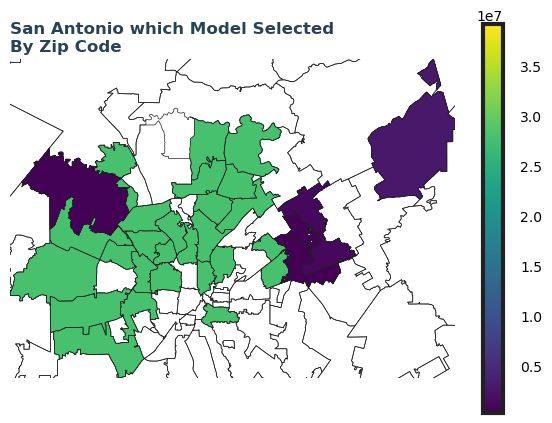

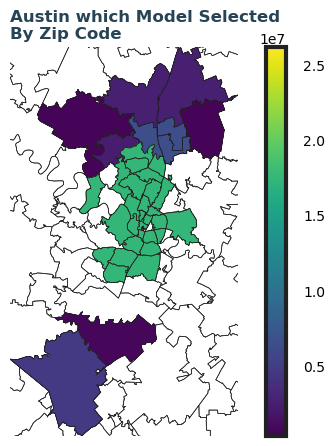

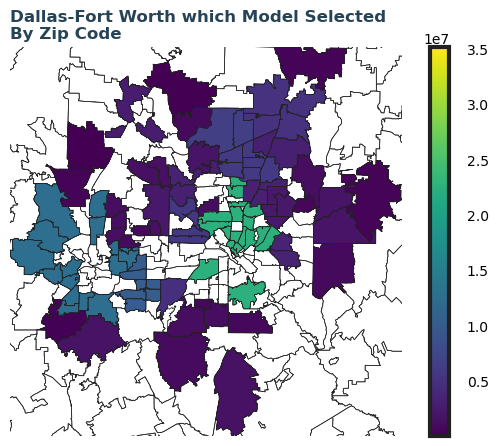

In [36]:
# color = ['#882255','#cc6677','#88ccee','#332288']
# zips_code = [0,1,2,3]
# color_mapping = dict(zip(zips_code,four_colors))

map_ = test
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["total_sales_tax_12_month_shift"], 
#                   color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' which Model Selected\nBy Zip Code')
    plt.show()

In [37]:
test

,Time,zip_code,zori_ssa,zori_ssa_12_month_shift,zori_ssa_1_diff_lag_12,zori_ssa_6_diff_lag_12,zori_ssa_12_diff_lag_12_per,mintempC_12_month_shift,sales_tax_rate_12_month_shift,total_sales_tax_12_month_shift,...,tx_net_approve_12_month_shift,pred,pred_difference,pred_12_month_growth,actual_12_month_growth,pred_12_month_growth_per,actual_12_month_growth_per,pred_difference_per,month,invest_rec_5_per
0,2020-08-01,76135.0,1488.0,1409.0,4.0,19.0,0.030518,27.129032,1.0,14975148.66,...,21.0,1459.190909,28.809091,50.190909,79.0,0.035622,0.056068,0.020446,8,2
1,2020-08-01,76107.0,1495.0,1477.0,0.0,2.0,0.018280,27.129032,1.0,14975148.66,...,21.0,1498.295853,-3.295853,21.295853,18.0,0.014418,0.012187,-0.002231,8,0
2,2020-08-01,75062.0,1587.0,1512.0,6.0,42.0,0.052249,27.129032,1.0,6690393.59,...,21.0,1573.986251,13.013749,61.986251,75.0,0.040996,0.049603,0.008607,8,2
3,2020-08-01,78753.0,1244.0,1202.0,8.0,47.0,0.066556,25.225806,1.0,20756830.56,...,21.0,1262.419460,-18.419460,60.419460,42.0,0.050266,0.034942,-0.015324,8,2
4,2020-08-01,78744.0,1228.0,1226.0,2.0,20.0,0.043230,25.225806,1.0,20756830.56,...,21.0,1254.355824,-26.355824,28.355824,2.0,0.023129,0.001631,-0.021497,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,2021-07-01,75229.0,1958.0,1880.0,12.0,67.0,0.054255,28.161290,1.0,22537425.60,...,-7.0,1970.997056,-12.997056,90.997056,78.0,0.048403,0.041489,-0.006913,7,2
2564,2021-07-01,75252.0,1151.0,1085.0,1.0,8.0,0.029493,28.161290,1.0,22537425.60,...,-7.0,1108.445678,42.554322,23.445678,66.0,0.021609,0.060829,0.039221,7,1
2565,2021-07-01,77079.0,1395.0,1363.0,-4.0,-24.0,-0.015407,27.161290,1.0,49456704.04,...,-7.0,1364.616249,30.383751,1.616249,32.0,0.001186,0.023478,0.022292,7,0
2566,2021-07-01,78745.0,1375.0,1280.0,0.0,7.0,0.028125,25.354839,1.0,17488618.80,...,-7.0,1304.161600,70.838400,24.161600,95.0,0.018876,0.074219,0.055342,7,1


In [38]:
merged_df.columns.to_list()

['Time',
 'zip_code',
 'zori_ssa',
 'zori_ssa_12_month_shift',
 'zori_ssa_1_diff_lag_12',
 'zori_ssa_6_diff_lag_12',
 'zori_ssa_12_diff_lag_12_per',
 'mintempC_12_month_shift',
 'sales_tax_rate_12_month_shift',
 'total_sales_tax_12_month_shift',
 'tx_is_abt_same_12_month_shift',
 'tx_is_better_12_month_shift',
 'tx_is_worse_12_month_shift',
 'Single Family Building Permits TX_12_month_shift',
 'taxpayer_count_12_month_shift',
 'taxpayer_cl_ratio_12_month_shift',
 'taxpayer_is_ratio_12_month_shift',
 'taxpayer_foreign_ratio_12_month_shift',
 'mintempC_annual_pct_change_12_month_shift',
 'sales_tax_rate_annual_pct_change_12_month_shift',
 'total_sales_tax_annual_pct_change_12_month_shift',
 'tx_is_abt_same_annual_pct_change_12_month_shift',
 'tx_is_better_annual_pct_change_12_month_shift',
 'tx_is_worse_annual_pct_change_12_month_shift',
 'Single Family Building Permits TX_annual_pct_change_12_month_shift',
 'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
 'sap_cas

In [39]:
forecast['pred_12_month_growth_per'] = ((forecast['pred']-
                                         forecast['zori_ssa_12_month_shift'])/
                                        forecast['pred'])
checkzz = forecast[['Time','pred_12_month_growth_per','zori_ssa_12_month_shift','pred',
                   'zip_code']]

In [40]:
pred_growth = checkzz.groupby('zip_code').agg(
    mean_pred_growth=('pred_12_month_growth_per', 'mean'),
    std_pred_growth=('pred_12_month_growth_per', 'std'),
).reset_index()

In [41]:
pred_growth.sort_values('mean_pred_growth').to_csv('hot_spots.csv')

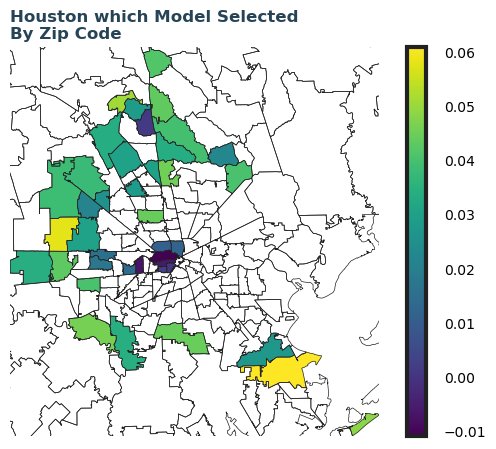

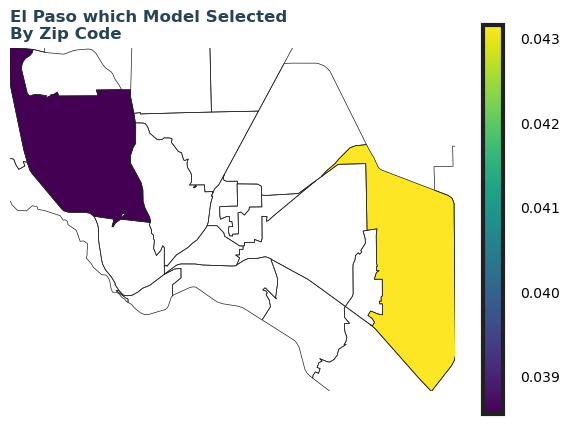

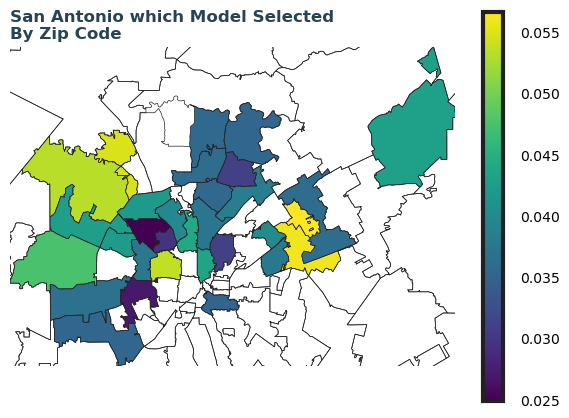

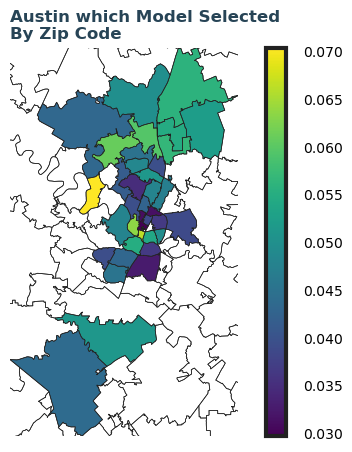

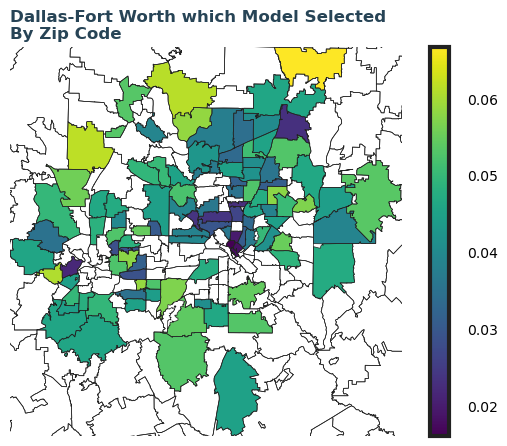

In [42]:
map_ = pred_growth
# dictionary of each cities zipcodes
different_metros = {'Houston' : houston_zips, 
                    'El Paso' : paso_zips, 
                    'San Antonio' : san_zips, 
                    'Austin' : austin_zips, 
                    'Dallas-Fort Worth' : dallas_zips}

# looping the graphing to make sure it works
for metro in different_metros.keys():
    graph_df = different_metros[metro].merge(map_, right_on='zip_code' ,left_on='GEOID10')
    fig,ax = plt.subplots()
    zip_boundry_map = zips.boundary.plot(color='#212121', linewidth=.5,ax=ax)
    graph_df.plot(ax=zip_boundry_map, 
                     column = graph_df["mean_pred_growth"], 
#                   color=graph_df["invest_rec_5_per"].map(color_mapping),
                  legend=True,
                    )

    zip_boundry_map.axis('off')

    minx, miny, maxx, maxy = graph_df.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    plt.title(metro +' which Model Selected\nBy Zip Code')
    plt.show()